In [19]:
%run ./load_vix.py

Fetching 2026-02-14 -> 2026-02-17 from Yahoo for ^VIX ...


C:\Users\nick5\dev\hypercube_ai\ai\treetrader\load_vix.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.isoformat(), end=end_exclusive.isoformat(), progress=False)


             open   high        low  close
Date                                      
2026-02-17  21.74  22.23  21.639999  21.74
Appended 1 rows; saved hist_data\kaggle\vix_daily.csv (total rows: 9099)


In [20]:
import ta
import pandas as pd

vix_df = pd.read_csv('./hist_data/kaggle/vix_daily.csv', parse_dates=['index'])

In [21]:

vix_df = vix_df.set_index('index')
vix_df.head()
vix_df['SMA_10'] = (vix_df['close'] - ta.trend.sma_indicator(vix_df['close'], window=10)) / vix_df['close']
vix_df['SMA_30'] = (vix_df['close'] - ta.trend.sma_indicator(vix_df['close'], window=30)) / vix_df['close']
vix_df['EMA_10'] = (vix_df['close'] - ta.trend.ema_indicator(vix_df['close'], window=10)) / vix_df['close']
vix_df['EMA_30'] = (vix_df['close'] - ta.trend.ema_indicator(vix_df['close'], window=30)) / vix_df['close']
vix_df['RSI'] = ta.momentum.rsi(vix_df['close'], window=14) / 100
vix_df['MACD'] = ta.trend.macd(vix_df['close'])
vix_df['MACD_Signal'] = ta.trend.macd_signal(vix_df['close'])

vix_df = vix_df.dropna()
vix_df.head()

,open,high,low,close,SMA_10,SMA_30,EMA_10,EMA_30,RSI,MACD,MACD_Signal
index,,,,,,,,,,,
1990-02-16,20.780001,20.780001,20.780001,20.780001,-0.114822,-0.154524,-0.093277,-0.102696,0.406281,-0.133833,0.563419
1990-02-20,22.780001,22.780001,22.780001,22.780001,-0.009219,-0.056848,0.002216,-0.005504,0.490742,-0.137011,0.423333
1990-02-21,23.889999,23.889999,23.889999,23.889999,0.041021,-0.010102,0.039744,0.038556,0.530649,-0.049392,0.328788
1990-02-22,22.540001,22.540001,22.540001,22.540001,-0.008651,-0.070748,-0.014538,-0.017801,0.481254,-0.087874,0.245456
1990-02-23,23.690001,23.690001,23.690001,23.690001,0.040650,-0.023892,0.028400,0.029568,0.522067,-0.025285,0.191308


In [22]:
import jax.numpy as jnp
train_test_split = 0.8
#vix_df['returns'] = (vix_df['close'] - vix_df['open']) / vix_df['open']
#vix_df['returns'] = vix_df['returns'].shift(-1)
vix_df = vix_df.dropna()
input_features = ['close', 'SMA_10', 'SMA_30', 'EMA_10', 'EMA_30', 'RSI', 'MACD', 'MACD_Signal']
INPUTS = jnp.array(vix_df[input_features].values)
vix_df['returns'] = vix_df['open'].pct_change().shift(-2)
vix_df = vix_df.dropna()

RETURNS = jnp.expand_dims(jnp.array(vix_df['returns'].values), 1)

sample_count = INPUTS.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = INPUTS[train_size:, :]
TEST_RETURNS = RETURNS[train_size:, :]
INPUTS = INPUTS[:train_size, :]
RETURNS = RETURNS[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")
print(f"Shape of TEST_INPUTS: {TEST_INPUTS.shape}")
print(f"Shape of TEST_RETURNS: {TEST_RETURNS.shape}")

Sample Count: 9066
Train Size: 7252
Shape of INPUTS: (7252, 8)
Shape of RETURNS: (7252, 1)
Shape of TEST_INPUTS: (1814, 8)
Shape of TEST_RETURNS: (1812, 1)


In [23]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
EPISODE_LEN = 34

class TradingProblem(BaseProblem):
  jitable = True
  episode_len = EPISODE_LEN
  pop_size = 1000
  
  def __init__(self):
      super().__init__()
      self.pop_counter = 0
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params):
    self.pop_counter += 1
    if self.pop_counter % self.pop_size == 0:
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len
    ins = INPUTS[self.start_idx:self.end_idx]
    returns = RETURNS[self.start_idx:self.end_idx]
    actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS)
    actions_buy_sell = jnp.where(actions > 0.0, 1, 0)
    reward = actions_buy_sell * RETURNS
    return jnp.mean(reward)

  def show(self, state, randkey, act_func, params, *args, **kwargs):
    # get actions as a host numpy array
    actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
    actions_buy_sell = jnp.where(actions > 0.0, 1, 0)

    # move data to host numpy
    from jax import device_get
    import numpy as np
    actions_np = np.asarray(device_get(actions_buy_sell)).ravel()
    returns_np = np.asarray(device_get(TEST_RETURNS)).ravel()
    print("latest actions", actions_np[-5:])
    perf = 100.0
    perf_hist = []
    for i in range(len(actions_np)-2):
      perf += perf * float(returns_np[i] * actions_np[i])
      perf_hist.append(float(perf))

    # plot using numpy list of floats
    import matplotlib.pyplot as plt
    plt.plot(perf_hist)
    print(perf_hist[0], perf_hist[-1])
    plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblem()

save to ./model_archive/tensorneat_checkpoints
initializing
initializing finished
(100, 4) (1500, 3)
latest actions [0 0 0 0 0]
102.84182671457529 111378.41065816586


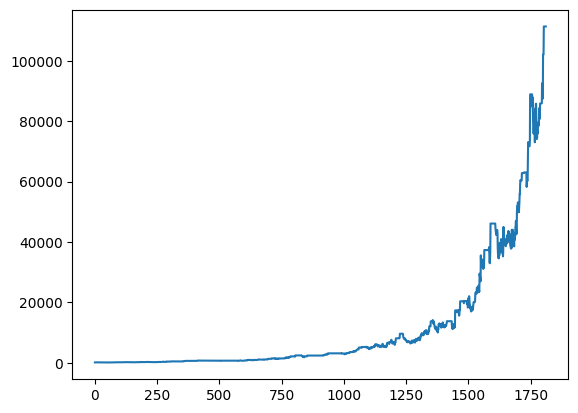

In [24]:
import jax.numpy as jnp
import numpy as np
from tensorneat.pipeline import Pipeline
from tensorneat.algorithm.neat import NEAT
from tensorneat.genome import DefaultGenome, BiasNode, DefaultConn, DefaultMutation
from tensorneat.problem.func_fit import CustomFuncFit
from tensorneat.common import ACT, AGG
from tensorneat import algorithm

# Construct the pipeline and run
pipeline = Pipeline(
    algorithm=NEAT(
        pop_size=610,
        species_size=13,
        survival_threshold=0.1,
        compatibility_threshold=0.8,
        genome=DefaultGenome(
            max_nodes=100,
            max_conns=1500,
            num_inputs=8,
            num_outputs=1,
            init_hidden_layers=(2,),
            node_gene=BiasNode(
                bias_init_std=0.1,
                bias_mutate_power=0.05,
                bias_mutate_rate=0.01,
                bias_replace_rate=0.0,
                activation_options=ACT.tanh,
                aggregation_options=AGG.sum,
            ),
            conn_gene=DefaultConn(
                weight_init_mean=0.0,
                weight_init_std=0.1,
                weight_mutate_power=0.05,
                weight_replace_rate=0.0,
                weight_mutate_rate=0.001,
            ),
            output_transform=ACT.tanh,
        ),
    ),
    problem=TradingProblem(),
    generation_limit=5,
    fitness_target=.01,
    seed=42,
    is_save=True,
    save_dir="./model_archive/tensorneat_checkpoints"
)

# initialize state
state = pipeline.setup()
best_path = "./model_archive/vix_champs/goat.npz"
best_genome = np.load(best_path)
nodes = best_genome['nodes']
conns = best_genome['conns']
nodes_j = jnp.array(nodes)
conns_j = jnp.array(conns)
print(nodes.shape, conns.shape) 
# show result
pipeline.show(state, (nodes_j, conns_j))
